In [1]:
from BiasStudy import datasets, predictionKit
from BiasStudy.datasets import FairFaceDataset
from BiasStudy.config.TrainingConfig import BiasStudyConfig
from BiasStudy.trainingKit import TrainingLogger
from BiasStudy.trainingKit.TrainingModel import BiasModel

Python Platform: Linux-5.19.0-45-generic-x86_64-with-glibc2.35
Tensor Flow Version: 2.12.1
Keras Version: 2.12.0

Python 3.8.19 (default, Apr  6 2024, 17:58:10) 
[GCC 11.4.0]


In [2]:
import os
import sys
import platform
import numpy as np
import tensorflow as tf
import tensorflow.keras
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import Model
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Conv2D
import numpy as np
import pandas as pd
from typing import List


In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load Models

In [4]:
RUN_ID = "h"

In [5]:
def get_run_description(run_id: str):  
    file_path = "/notebooks/code/training_workflow/layer_configs/run_{}/description.txt".format(run_id)

    with open(file_path, 'r') as file:
        file_content = file.read()

    print(file_content)

In [6]:
BASE_PATH_TO_WEIGHTS = "/notebooks/data/results/run_{0}/{1}_{2}/run_{0}_model_{1}conv_{2}kernel/model/model.h5"

def get_result_paths_dict(layers: List[int], kernel_sizes: List[int] , run_id: str) -> dict:
    get_run_description(RUN_ID)
    paths = {}
    for layer in layers:
        for kernel_size in kernel_sizes:
            paths["{}_{}".format(layer, kernel_size)] = BASE_PATH_TO_WEIGHTS.format(run_id, layer, kernel_size)
    
    return paths

In [7]:
run_h_model_paths = get_result_paths_dict(
    layers = [2, 4, 6, 8, 10],
    kernel_sizes = [3, 5],
    run_id = RUN_ID
)

* No flat 
* 20 epochs 
* 5 early epoch patience 
* With dropouts
* 0.0001 learning rate - Lower 
* Lower learning rate + dropout



In [8]:
def get_last_flat_layer_name(model: Model) -> str:
    last_layer_name = None
    for layer in model.layers:
        if type(layer) is Flatten:
            last_layer_name = layer.name
        if type(layer) is Dense and layer.units != 2:
            last_layer_name = layer.name
    return last_layer_name

In [9]:
def load_model_prep_for_bias_study(model_paths: dict, num_conv_layers: int, kernerl_size: int) -> Model:
    model = load_model(model_paths["{}_{}".format(num_conv_layers, kernerl_size)])
    embedding_layer = get_last_flat_layer_name(model)
    model_name = "{}Layers_{}Kernel".format(num_conv_layers, kernerl_size)
    print("{} - Embedding Layer: {}".format(model_name, embedding_layer))
    model.trainable = False
    return Model(
        name = model_name,
        inputs = model.input,
        outputs = model.get_layer(embedding_layer).output
    )

In [10]:
run_h_model_2_3 = load_model_prep_for_bias_study(model_paths = run_h_model_paths, num_conv_layers = 2, kernerl_size = 3)
run_h_model_2_5 = load_model_prep_for_bias_study(model_paths = run_h_model_paths, num_conv_layers = 2, kernerl_size = 5)

run_h_model_4_3 = load_model_prep_for_bias_study(model_paths = run_h_model_paths, num_conv_layers = 4, kernerl_size = 3)
run_h_model_4_5 = load_model_prep_for_bias_study(model_paths = run_h_model_paths, num_conv_layers = 4, kernerl_size = 5)

run_h_model_6_3 = load_model_prep_for_bias_study(model_paths = run_h_model_paths, num_conv_layers = 6, kernerl_size = 3)
run_h_model_6_5 = load_model_prep_for_bias_study(model_paths = run_h_model_paths, num_conv_layers = 6, kernerl_size = 5)

run_h_model_8_3 = load_model_prep_for_bias_study(model_paths = run_h_model_paths, num_conv_layers = 8, kernerl_size = 3)
run_h_model_8_5 = load_model_prep_for_bias_study(model_paths = run_h_model_paths, num_conv_layers = 8, kernerl_size = 5)

run_h_model_10_3 = load_model_prep_for_bias_study(model_paths = run_h_model_paths, num_conv_layers = 10, kernerl_size = 3)
run_h_model_10_5 = load_model_prep_for_bias_study(model_paths = run_h_model_paths, num_conv_layers = 10, kernerl_size = 5)

2Layers_3Kernel - Embedding Layer: flatten
2Layers_5Kernel - Embedding Layer: flatten
4Layers_3Kernel - Embedding Layer: flatten
4Layers_5Kernel - Embedding Layer: flatten
6Layers_3Kernel - Embedding Layer: flatten
6Layers_5Kernel - Embedding Layer: flatten
8Layers_3Kernel - Embedding Layer: flatten
8Layers_5Kernel - Embedding Layer: flatten
10Layers_3Kernel - Embedding Layer: flatten
10Layers_5Kernel - Embedding Layer: flatten


# Understand Model Training

In [11]:
BASE_PATH_TO_HISTORIES = "/notebooks/data/results/run_{0}/{1}_{2}/run_{0}_model_{1}conv_{2}kernel/csv_logging/logsrun_{0}_model_{1}conv_{2}kernel.csv"

def get_history_paths_dict(layers: List[int], kernel_sizes: List[int], run_id: str) -> dict:
    history_paths = {}
    for layer in layers:
        for kernel_size in kernel_sizes:
            history_paths["{}_{}".format(layer, kernel_size)] = BASE_PATH_TO_HISTORIES.format(run_id, layer, kernel_size)
    return history_paths

In [12]:
run_h_history_paths = get_history_paths_dict(
    layers = [2, 4, 6, 8, 10],
    kernel_sizes = [3, 5],
    run_id = RUN_ID
)

In [13]:
def read_csv_history(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df.epoch != 'epoch']
    df = df.reset_index(drop=True)
    df['index'] = df.index
    df = df.loc[df.groupby("epoch")["index"].idxmax()]
    df = df.astype(float)
    df = df.sort_values(by=['epoch'], ascending=True)
    df = df.reset_index(drop=True)
    return df.copy()

In [14]:
def plot_all(histories_dict):
    num_plots = len(histories_dict)
    f, axs = plt.subplots(1, num_plots, sharey=True, figsize=(num_plots * 5,  5))
    for idx, (key, history_path) in enumerate(histories_dict.items()):
        history = read_csv_history(history_path)
        axs[idx].plot(history.loss, label='training')
        axs[idx].plot(history.val_loss, label='validation')
        axs[idx].legend()
        axs[idx].set_title(key)
    plt.show()

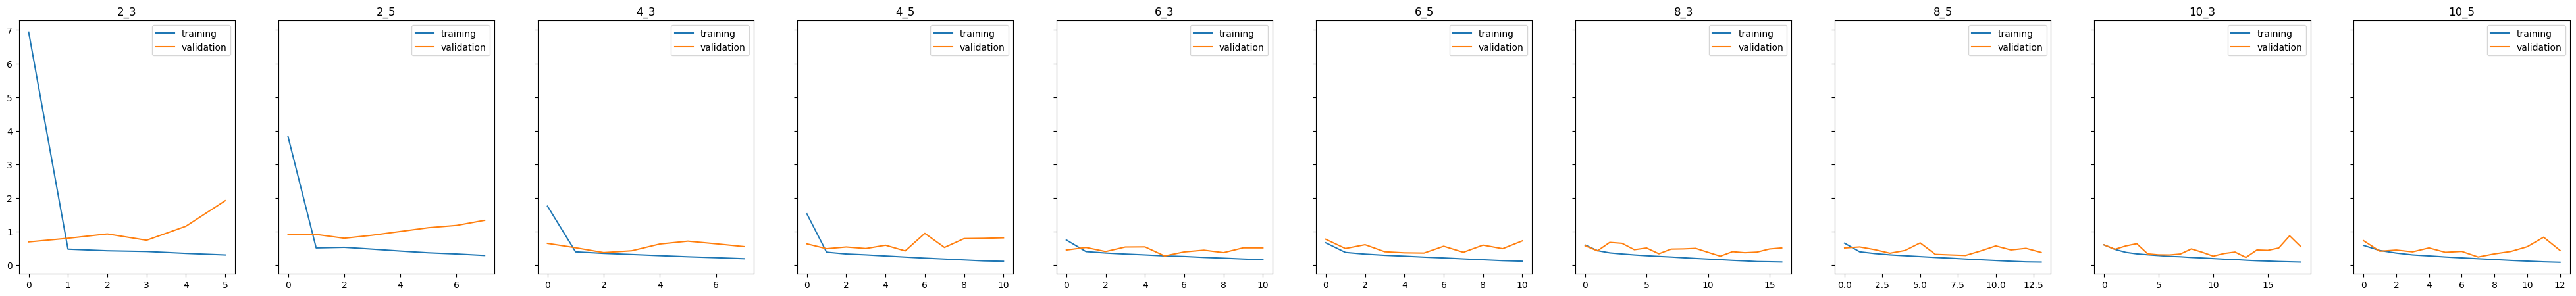

In [15]:
plot_all(run_h_history_paths)

# Load Dataset

In [16]:
IMAGE_DIR = "/notebooks/data/LFWA+/COMPILED/compiled_lfwa+"
BASE_DIR = "/notebooks/data/LFWA+/COMPILED"
ALL_PAIRS = "compiled_lfwa+_all_pairs.csv"

In [17]:
all_pairs =  pd.read_csv("{}/{}".format(BASE_DIR, ALL_PAIRS))

# Evaluation

In [18]:
from BiasStudy.predictionKit import PredictionToolKit
from BiasStudy.predictionKit import PredictionPlotKit

## 4Layers - 3 Kernel Size

In [25]:
run_h_model_4_3_bias_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = run_h_model_4_3,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [26]:
print(run_h_model_4_3_bias_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 62.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.070379045157855 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.659519916765755 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.275862068965517 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.137931034482759 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 22.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.076136313708901 |
+-------

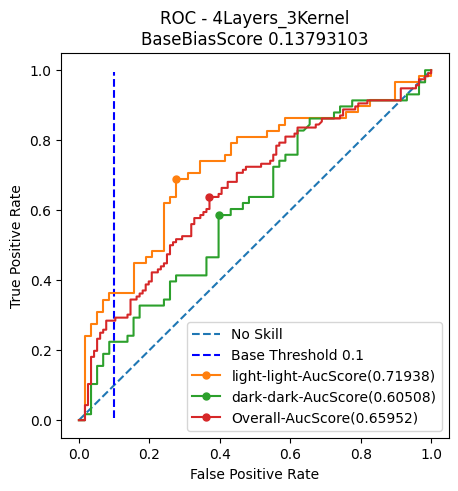

In [27]:
PredictionPlotKit.plot_roc(run_h_model_4_3_bias_result)

## 4Layers - 5 Kernel Size

In [28]:
run_h_model_4_5_bias_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = run_h_model_4_5,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [29]:
print(run_h_model_4_5_bias_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 44.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.056533961454097 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.666282699167657 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.172413793103448 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.120689655172414 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 22.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.061575216810631 |
+-------

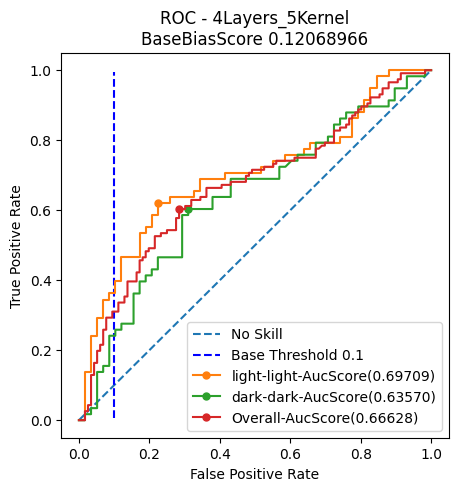

In [30]:
PredictionPlotKit.plot_roc(run_h_model_4_5_bias_result)

## 8Layers - 3 Kernel Size

In [37]:
run_h_model_8_3_bias_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = run_h_model_8_3,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [38]:
print(run_h_model_8_3_bias_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 46.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.149193362000299 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.688280321046373 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.103448275862069 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.103448275862069 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 24.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.150034204113764 |
+-------

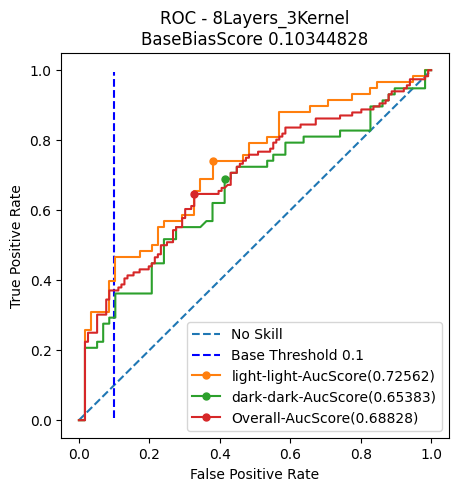

In [39]:
PredictionPlotKit.plot_roc(run_h_model_8_3_bias_result)

## 8Layers - 5 Kernel Size

In [40]:
run_h_model_8_5_bias_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = run_h_model_8_5,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [41]:
print(run_h_model_8_5_bias_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 42.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.161714587812486 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.682037752675386 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.172413793103448 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.172413793103448 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 20.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.163485119711570 |
+-------

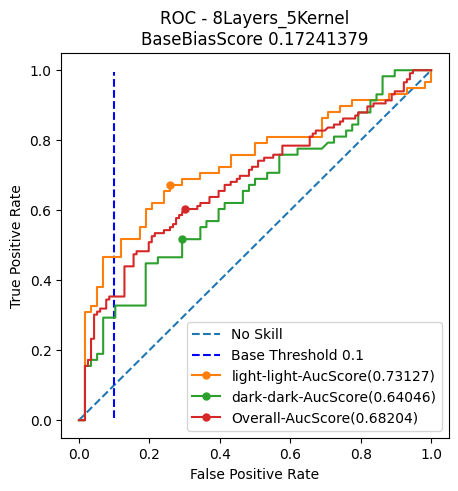

In [42]:
PredictionPlotKit.plot_roc(run_h_model_8_5_bias_result)

## 10Layers - 3 Kernel Size

In [43]:
run_h_model_10_3_bias_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = run_h_model_10_3,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [44]:
print(run_h_model_10_3_bias_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 48.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.264214567913622 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.676686979785969 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.172413793103448 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.017241379310345 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 26.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.264214567913622 |
+-------

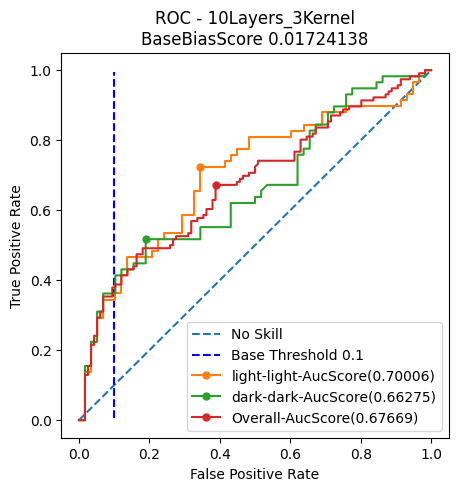

In [45]:
PredictionPlotKit.plot_roc(run_h_model_10_3_bias_result)

## 10Layers - 5Kernel Size

In [46]:
run_h_model_10_5_bias_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = run_h_model_10_5,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [47]:
print(run_h_model_10_5_bias_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 44.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.273672278732793 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.659519916765755 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.103448275862069 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.051724137931035 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 22.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.269056150558761 |
+-------

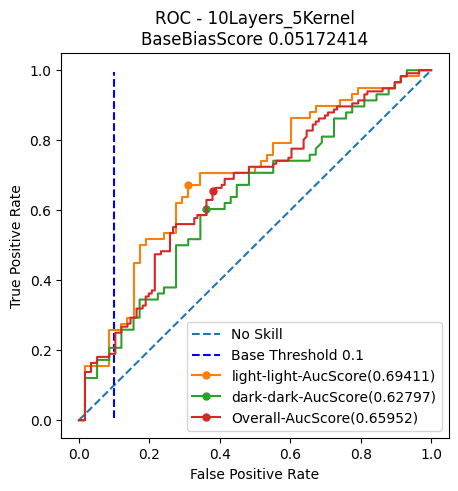

In [48]:
PredictionPlotKit.plot_roc(run_h_model_10_5_bias_result)

## ALL

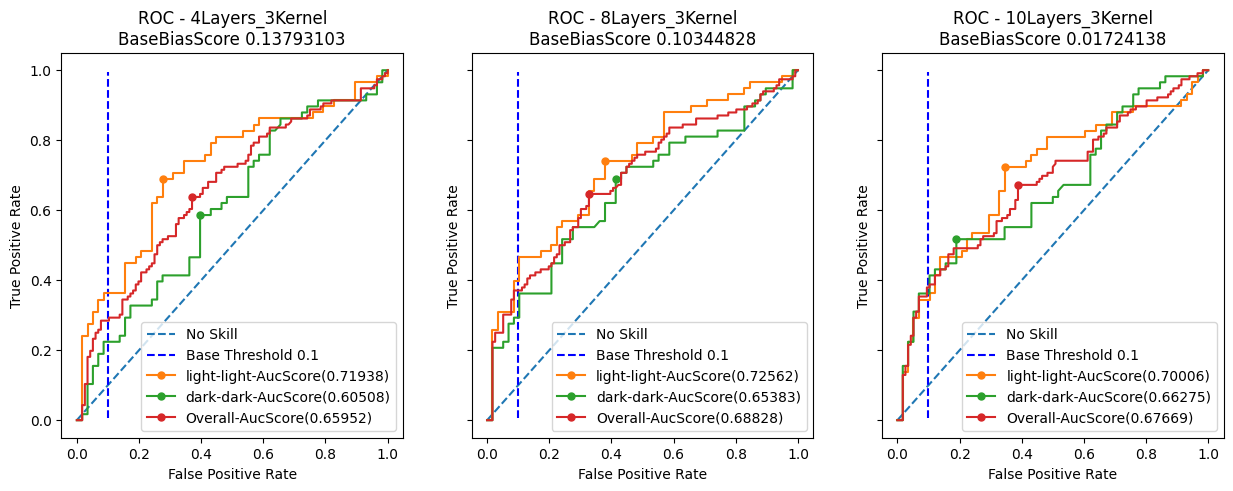

In [49]:
PredictionPlotKit.plot_multiple_roc(
    [
        run_h_model_4_3_bias_result,
        run_h_model_8_3_bias_result,
        run_h_model_10_3_bias_result
    ]
)

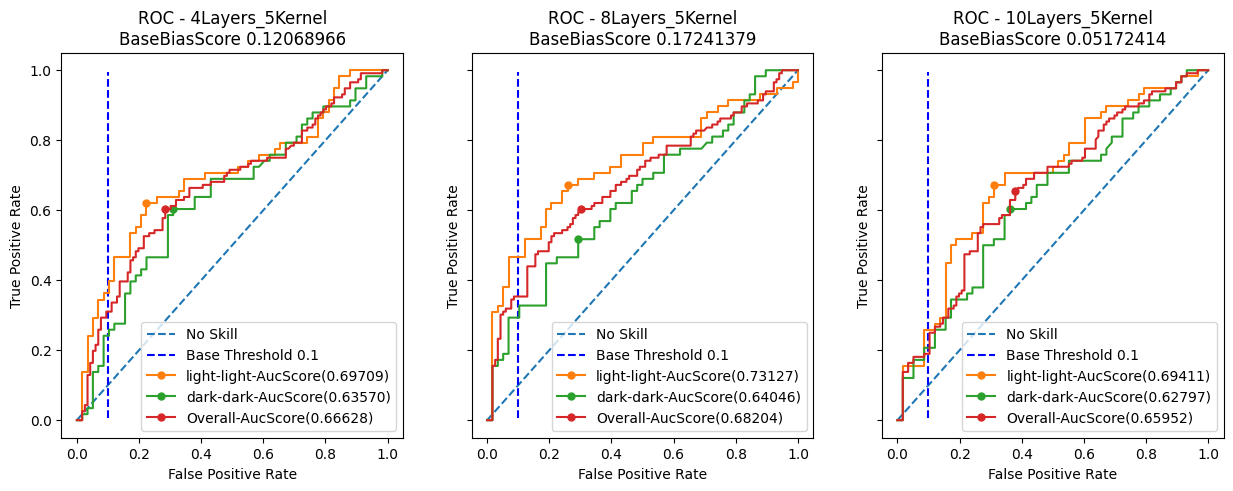

In [50]:
PredictionPlotKit.plot_multiple_roc(
    [
        run_h_model_4_5_bias_result,
        run_h_model_8_5_bias_result,
        run_h_model_10_5_bias_result
    ]
)

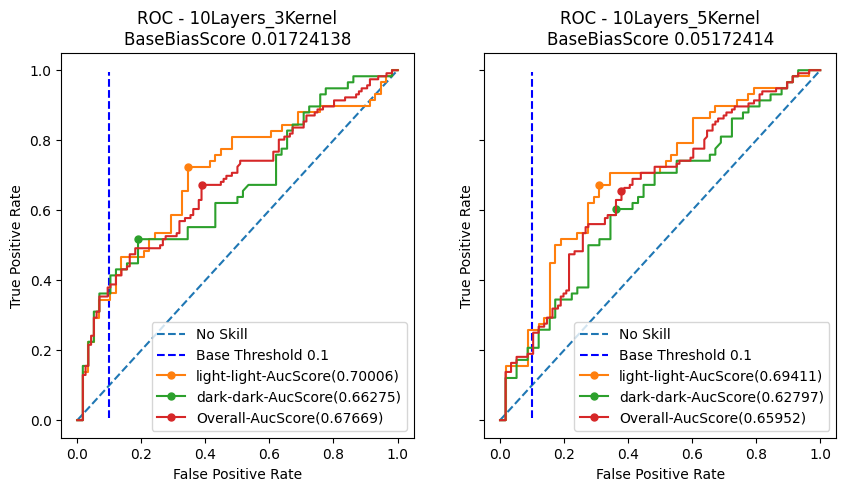

In [77]:
PredictionPlotKit.plot_multiple_roc(
    [
        run_h_model_10_3_bias_result,
        run_h_model_10_5_bias_result
    ]
)

# How do we tell that those values are statistically different ? Maybe compare the models to see if they are statistically different -> Make the judgment there
# In case the comparing of the models did not give a better understanding and we couldn't explain it ---> Either we include that for 4_3 -> 4_5 we couldn't explain why 

In [52]:
print("4_3: {}".format(run_h_model_4_3_bias_result.get_bias_score_dict()))
print("8_3: {}".format(run_h_model_8_3_bias_result.get_bias_score_dict()))
print("10_3: {}".format(run_h_model_10_3_bias_result.get_bias_score_dict()))

4_3: {'fpr_at_best_threshold': {'fpr': 0.3706896551724138, 'bias_score': 0.2758620689655173}, 'base_fpr': {'fpr': 0.1, 'bias_score': 0.13793103448275862}}
8_3: {'fpr_at_best_threshold': {'fpr': 0.3275862068965517, 'bias_score': 0.10344827586206895}, 'base_fpr': {'fpr': 0.1, 'bias_score': 0.103448275862069}}
10_3: {'fpr_at_best_threshold': {'fpr': 0.3879310344827586, 'bias_score': 0.1724137931034483}, 'base_fpr': {'fpr': 0.1, 'bias_score': 0.017241379310344807}}


In [53]:
print("4_5: {}".format(run_h_model_4_5_bias_result.get_bias_score_dict()))
print("8_5: {}".format(run_h_model_8_5_bias_result.get_bias_score_dict()))
print("10_5: {}".format(run_h_model_10_5_bias_result.get_bias_score_dict()))

4_5: {'fpr_at_best_threshold': {'fpr': 0.28448275862068967, 'bias_score': 0.17241379310344834}, 'base_fpr': {'fpr': 0.1, 'bias_score': 0.12068965517241378}}
8_5: {'fpr_at_best_threshold': {'fpr': 0.3017241379310345, 'bias_score': 0.1724137931034483}, 'base_fpr': {'fpr': 0.1, 'bias_score': 0.1724137931034483}}
10_5: {'fpr_at_best_threshold': {'fpr': 0.3793103448275862, 'bias_score': 0.10344827586206895}, 'base_fpr': {'fpr': 0.1, 'bias_score': 0.0517241379310345}}


# BPC

In [65]:
def bpc(bias_score_model, bias_score_for_dibased_model):
    return (bias_score_model - bias_score_for_dibased_model)/bias_score_model

In [69]:
print(
    "FROM 4_3 to 8_3 BPC Score - {}".format(
        bpc(
            run_h_model_4_3_bias_result.get_base_bias_score(), 
            run_h_model_8_3_bias_result.get_base_bias_score()
        )
    )
)

print(
    "FROM 8_3 to 10_3 BPC Score - {}".format(
        bpc(
            run_h_model_8_3_bias_result.get_base_bias_score(), 
            run_h_model_10_3_bias_result.get_base_bias_score()
        )
    )
)

FROM 4_3 to 8_3 BPC Score - 0.2499999999999997
FROM 8_3 to 10_3 BPC Score - 0.8333333333333336


In [70]:
print(
    "FROM 4_5 to 8_5 BPC Score - {}".format(
        bpc(
            run_h_model_4_5_bias_result.get_base_bias_score(), 
            run_h_model_8_5_bias_result.get_base_bias_score()
        )
    )
)

print(
    "FROM 8_5 to 10_5 BPC Score - {}".format(
        bpc(
            run_h_model_8_5_bias_result.get_base_bias_score(), 
            run_h_model_10_5_bias_result.get_base_bias_score()
        )
    )
)

FROM 4_5 to 8_5 BPC Score - -0.42857142857142877
FROM 8_5 to 10_5 BPC Score - 0.7


In [79]:
print(
    "FROM 4_3 to 4_5 BPC Score - {}".format(
        bpc(
            run_h_model_4_3_bias_result.get_base_bias_score(), 
            run_h_model_4_5_bias_result.get_base_bias_score()
        )
    )
)

print(
    "FROM 8_3 to 8_5 BPC Score - {}".format(
        bpc(
            run_h_model_8_3_bias_result.get_base_bias_score(), 
            run_h_model_8_5_bias_result.get_base_bias_score()
        )
    )
)


print(
    "FROM 10_3 to 10_5 BPC Score - {}".format(
        bpc(
            run_h_model_10_3_bias_result.get_base_bias_score(), 
            run_h_model_10_5_bias_result.get_base_bias_score()
        )
    )
)

FROM 4_3 to 4_5 BPC Score - 0.12500000000000006
FROM 8_3 to 8_5 BPC Score - -0.6666666666666662
FROM 10_3 to 10_5 BPC Score - -2.000000000000005
